# Music Recommendation System
MAFS 6010S Course Project 
Wong Hoi Ming, 20641276

In this project, we are going to apply gradient boosting trees to build a music recommendation system.

We will go straight into the implementation part, followed by results analysis, as a clear description of the data set can be find in the following link.
https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data


##Data Processing

We first import our data sets. 

In [2]:
#Import data and install the necessary packages
import pandas as pd
import numpy as np

memb = pd.read_csv("members.csv",sep = ",",dtype={'city' : 'category','bd' : np.uint8,
                                                      'gender' : 'category','registered_via' : 'category'},
                                                  parse_dates=['registration_init_time','expiration_date'])
songs = pd.read_csv("songs.csv",sep = ",", dtype={'genre_ids': 'category','language' : 'category',
                                                  'artist_name' : 'category','composer' : 'category',
                                                  'lyricist' : 'category','song_id' : 'category'})
testdata = pd.read_csv("test.csv",sep = ",", dtype={'msno' : 'category','source_system_tab' : 'category',
                                                  'source_screen_name' : 'category','source_type' : 'category',
                                                  'target' : np.uint8,'song_id' : 'category'})
traindata = pd.read_csv("train.csv",sep = ",", dtype={'msno' : 'category','source_system_tab' : 'category',
                                                  'source_screen_name' : 'category','source_type' : 'category',
                                                  'target' : np.uint8,'song_id' : 'category'})
songs_extra = pd.read_csv("song_extra_info.csv",sep = ",")


After reading in the data set, we are going to merge them.
Before that, we create a variable to measure the time registration to expiry.
This will be subsequently used in place of the exact dates.

In [3]:
#Before we merge the data set,
#we create a variable to measure the time from registration to expiry

memb['membership_days'] = memb['expiration_date'].subtract(memb['registration_init_time']).dt.days.astype(int)

#Here we merge the data set
traindata = traindata.merge(songs, on='song_id', how='left')
testdata = testdata.merge(songs, on='song_id', how='left')

traindata = traindata.merge(memb, on='msno', how='left')
testdata = testdata.merge(memb, on='msno', how='left')


We verify whether all the observations are recording first observable listening events, and therefore we check if each song is only matched with one membership number once in the training data. 

In [3]:
traindata['song_id+memb_no'] = traindata['msno'] + traindata['song_id']
song_count_tr = traindata.loc[:,['song_id+memb_no',"song_length"]]
song_count = song_count_tr.groupby(['song_id+memb_no'],as_index=False).count().rename(columns = {"song_length":"match_count"})
print(np.max(song_count['match_count']))
traindata = traindata.drop(['song_id+memb_no'],axis=1)

1


We have an overview of the number of missing values across each of the predicting variable.
We replace the missing values in song_lenght with the mean.
We consider the missing values in gender as 'undisclosed'. So 'male' and 'female' is now respectively considered to be a male and female user willing to disclose his/her gender information in registration.

In [23]:
print(traindata.isnull().sum())
# We replace the missing values in song_length with the mean.
traindata['song_length'] = traindata['song_length'].fillna(np.nanmean(traindata['song_length']))
# We consider the missing values in gender as 'undisclosed'
traindata['gender'] = traindata['gender'].astype('object')
traindata['gender'][traindata['gender']=='nan'] = 'undisclosed'
traindata['gender'] = traindata['gender'].astype('category')

msno                            0
song_id                         0
source_system_tab           24849
source_screen_name         414804
source_type                 21539
target                          0
song_length                   114
genre_ids                  118455
artist_name                   114
composer                  1675706
lyricist                  3178798
language                      150
city                            0
bd                              0
gender                    2961479
registered_via                  0
registration_init_time          0
expiration_date                 0
membership_days                 0
dtype: int64


Then we will split our train data into a train set and validation set. We will use 75% of data for training and 25% for validation. Also, some new features will be added, including the number of times a song is played in the set within the time horizon of testing set. 

In [43]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from lightgbm import LGBMClassifier

# We split the data into training and validation sets
X = traindata.drop(['registration_init_time','expiration_date'], axis=1)
y = traindata['target'].values
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=5)

########################## Adding features specific to each of train & validation set#################################
#This is to prevent the train set from having the info in validation set

### Add # of times a song is played
# In the training data set, we define a new feature to count the number of times that each song is played
song_count_tr = X_tr.loc[:,["song_id","song_length"]]
song_count1 = song_count_tr.groupby(["song_id"],as_index=False).count().rename(columns = {"song_length":"play_count"})
X_tr = X_tr.merge(song_count1,on="song_id",how="left")
del song_count_tr, song_count1

#Do it similarly for the testing set
song_count_val = X_val.loc[:,["song_id","song_length"]]
song_count2 = song_count_val.groupby(["song_id"],as_index=False).count().rename(columns = {"song_length":"play_count"})
X_val = X_val.merge(song_count2,on="song_id",how="left")
del song_count_val, song_count2

X_tr = X_tr.drop(['target','msno','song_id'], axis=1)
X_val = X_val.drop(['target','msno','song_id'], axis=1)


##Model Implementation

To fit our GBT model, we select a learning parameter of 0.2 in order to balance the learning pace with avoidance of overfitting. We constrain each tree to at most have 2^8 leaves, and we set the number of iterations to 250, as previous attempts show that the AUC in validation set improves relatively slowly after 250 rounds of calculations

The AUC score of our final GB tree in the validation data set is about 0.74.

In [47]:
import time
time_start = time.clock()
# This is the model fitting part
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 2**8,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 250,
        'metric' : 'auc'
    }

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_val = lgb.Dataset(X_val, y_val)
lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=25)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)


time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[25]	valid_0's auc: 0.713432
[50]	valid_0's auc: 0.722358
[75]	valid_0's auc: 0.727879
[100]	valid_0's auc: 0.731149
[125]	valid_0's auc: 0.733624
[150]	valid_0's auc: 0.736488
[175]	valid_0's auc: 0.73805
[200]	valid_0's auc: 0.73858
[225]	valid_0's auc: 0.739622
[250]	valid_0's auc: 0.740247


time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


210.26590670000223


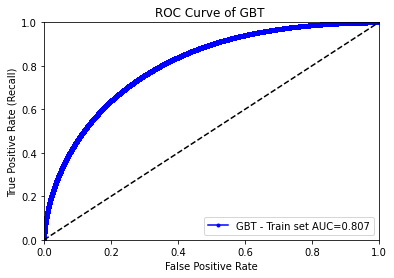

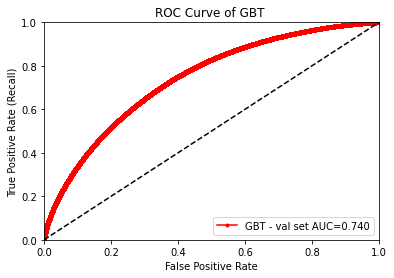

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, accuracy_score, auc
###Plot the ROC curves and find the AUC
pred = lgbm_model.predict(X_tr)
fpr, tpr, thresholds = roc_curve(y_tr, pred, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label="GBT - Train set AUC=%0.3f" % roc_auc, marker ='.')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.title("ROC Curve of GBT ")
plt.ylabel("True Positive Rate (Recall)")
plt.xlabel("False Positive Rate")
plt.show()

pred = lgbm_model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, pred, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', label="GBT - val set AUC=%0.3f" % roc_auc, marker ='.')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.title("ROC Curve of GBT ")
plt.ylabel("True Positive Rate (Recall)")
plt.xlabel("False Positive Rate")
plt.show()

##Results Interpretation

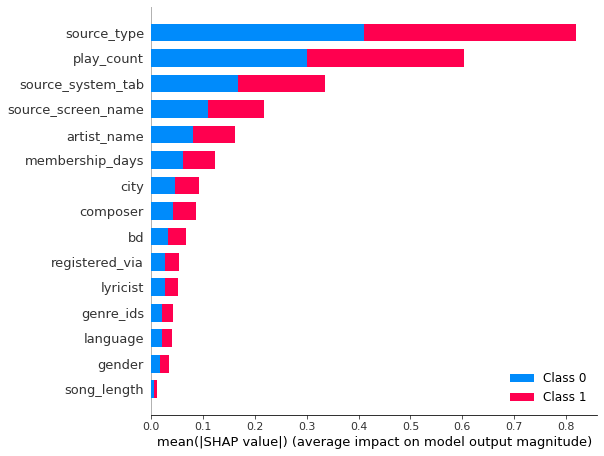

In [11]:
import shap
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)


From the above summary plot of Shapley values, it can be observed that [source_type], the entry point a user first plays a particular song. [source_screen_name], the layout the user see, and [source_system_tab], the tab where the listening event occured, are also relatively more useful in the prediction of recurring listening events.

In the bar charts below, for [source_type], it can be shown that there is a notably higher chance of recurring listening if the user first listened to the song via local library and local playlist. If the song came to the user via radio, there is notably lower chance of recurring listening. Songs being included in the user's own local playlist or library may have hinted at a user's positve preference for the song. Similar patterns can be observed for [source_screen_name] and [source_system_tab]. Local playists/library seems more preferred by users, while radio is much less preferred.

Other than the source of the music, [play_count] sees to be another dimension useful for the prediction. From the table below the bar charts, recurring listening tends to associated with songs that were played more. Songs that were played more may suggest they are more popular or they are more easily accessed by users by any media, which in turn heightens the chance of recurring listening.



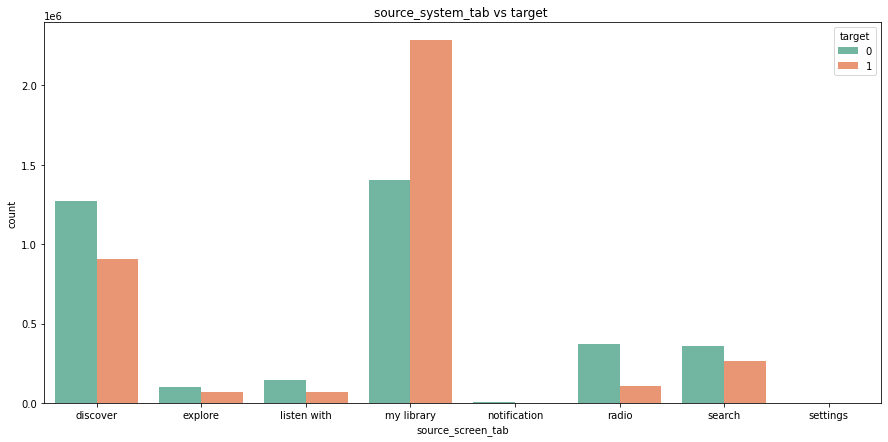

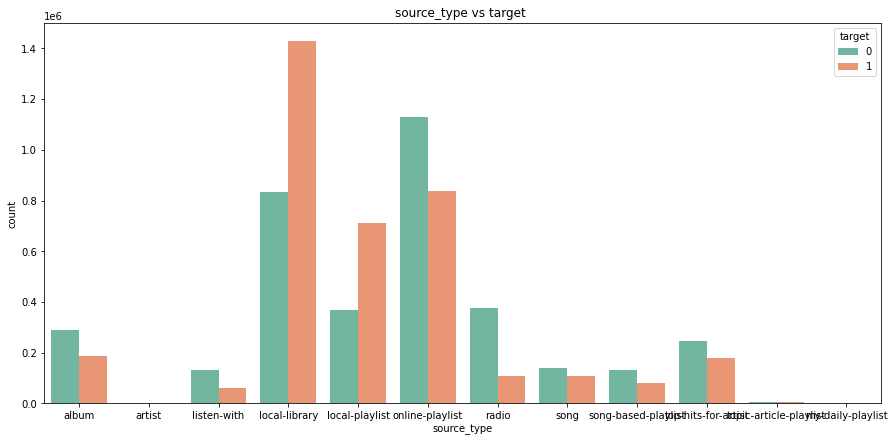

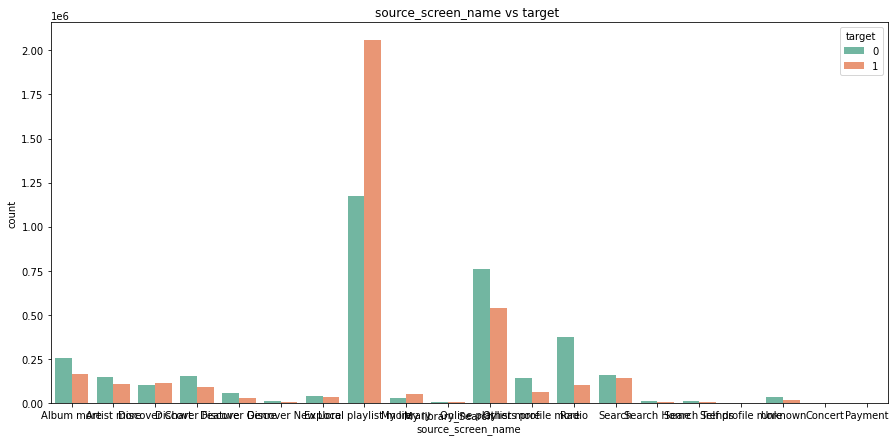

   play_count   play_count
0           0  1239.761114
1           1  2036.482422
   artist_count  artist_count
0             0  36365.598069
1             1  43240.808405


In [94]:
import seaborn as sb
import matplotlib.pyplot as plt

a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sb.countplot(x="source_system_tab",data=traindata,palette=sb.color_palette("Set2"),hue="target")
plt.xlabel("source_screen_tab")
plt.ylabel("count")
plt.title("source_system_tab vs target ")
plt.show()

a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sb.countplot(x="source_type",data=traindata,palette=sb.color_palette("Set2"),hue="target")
plt.xlabel("source_type")
plt.ylabel("count")
plt.title("source_type vs target ")
plt.show()

a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sb.countplot(x="source_screen_name",data=traindata,palette=sb.color_palette("Set2"),hue="target")
plt.xlabel("source_screen_name")
plt.ylabel("count")
plt.title("source_screen_name vs target ")
plt.show()

song_count = X.loc[:,["song_id","song_length"]]
song_count1 = song_count.groupby(["song_id"],as_index=False).count().rename(columns = {"song_length":"play_count"})
artist_count = X.loc[:,["artist_name","song_length"]]
artist_count1 = artist_count.groupby(["artist_name"],as_index=False).count().rename(columns = {"song_length":"artist_count"})
X_explain = X.merge(song_count1,on="song_id",how="left") 
X_explain = X_explain.merge(artist_count1,on="artist_name",how="left") 

# The following shows that a song tends to be played again in one month if it has been played more in our existing dataset
song_target = X_explain.loc[:,["target","play_count"]]
song_target2 = song_target.groupby(["target"],as_index=False).mean().rename(columns = {"target":"play_count"})

print(song_target2.head())


In [106]:
# 5-fold Cross Validation
from sklearn.model_selection import KFold
### K-fold validation

kf = KFold(n_splits=5,shuffle=True)
X = traindata.drop(['registration_init_time','expiration_date'], axis=1)
y = traindata['target'].values
kf.split(X)

#First Define a function for fitting the tree, which will be repetitively called for CV
def GBT_auc(X_tr,y_tr,X_val,y_val,max_depth):
    
    song_count_tr = X_tr.loc[:,["song_id","song_length"]]
    song_count1 = song_count_tr.groupby(["song_id"],as_index=False).count().rename(columns = {"song_length":"play_count"})
    X_tr = X_tr.merge(song_count1,on="song_id",how="left")
    del song_count_tr, song_count1

    song_count_val = X_val.loc[:,["song_id","song_length"]]
    song_count2 = song_count_val.groupby(["song_id"],as_index=False).count().rename(columns = {"song_length":"play_count"})
    X_val = X_val.merge(song_count2,on="song_id",how="left")
    del song_count_val, song_count2

    X_tr = X_tr.drop(['target','msno','song_id'], axis=1)
    X_val = X_val.drop(['target','msno','song_id'], axis=1)
    
    #
    params = {
            'objective': 'binary',
            'boosting': 'gbdt',
            'learning_rate': .2 ,
            'verbose': 0,
            'num_leaves': 2**max_depth,
            'feature_fraction': 0.9,
            'feature_fraction_seed': 1,
            'max_bin': 256,
            'num_rounds': 256,
            'metric' : 'auc'
        }

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val)
    lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=250)
    return lgbm_model.best_score['valid_0']['auc']
    
# Create a series of values for different max-depth
max_depth= np.arange(1,13,1)

for j in range(0,12):
    print("For tree size with depth = " + str(max_depth[j]))
    i = 1
    total=0
    for train_index, test_index in kf.split(X):
        # Split train-test
        X_tr, X_val = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_val = y[train_index], y[test_index]
        temp = GBT_auc(X_tr,y_tr,X_val,y_val,max_depth[j])
        total = total + temp
        print("#" +str(i)+" validation auc: ")
        print(temp)
        i+=1
    print('Average AUC = ')
    print(total/5)



For tree size with depth = 1
[250]	valid_0's auc: 0.687509
#1 validation auc: 
0.6876047563228835
[250]	valid_0's auc: 0.688153
#2 validation auc: 
0.6882065465829781
[250]	valid_0's auc: 0.687951
#3 validation auc: 
0.6879934282767131
[250]	valid_0's auc: 0.688037
#4 validation auc: 
0.6880637933608801
[250]	valid_0's auc: 0.687513
#5 validation auc: 
0.687545988950044
Average AUC = 
0.6878829026986998
For tree size with depth = 2
[250]	valid_0's auc: 0.692465
#1 validation auc: 
0.6925247618661606
[250]	valid_0's auc: 0.692508
#2 validation auc: 
0.6926239994947395
[250]	valid_0's auc: 0.692822
#3 validation auc: 
0.6929325194979775
[250]	valid_0's auc: 0.691938
#4 validation auc: 
0.692135532418135
[250]	valid_0's auc: 0.692446
#5 validation auc: 
0.6925535345461726
Average AUC = 
0.692554069564637
For tree size with depth = 3
[250]	valid_0's auc: 0.698156
#1 validation auc: 
0.6983318592671
[250]	valid_0's auc: 0.698106
#2 validation auc: 
0.6981596956647302
[250]	valid_0's auc: 0.